### Group Members: _Anar Kuatzhan, Shriya Vaagdevi Chikati_

# Setting up pyspark and graphFrame

In [ ]:
!pip install pyspark
!pip install graphframes
!curl -L -o "/usr/local/lib/python3.6/dist-packages/pyspark/jars/graphframes-0.8.2-spark3.2-s_2.12.jar" http://dl.bintray.com/spark-packages/maven/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar
!apt-get update -qq > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.4.2/spark-3.4.2-bin-hadoop3.tgz
!tar xf spark-3.4.2-bin-hadoop3.tgz
!pip install -q findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=5a2f885e979b8e92014817b54c90b085e83401dad7e66d66d49d9a18048ad071
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.4 MB/s eta 0:00:00
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   164  100   164    0     0   1034      0 --:--:-- --:--:-- --:--:--  1037
100   146  100   146    0     0    273      0 --:--:-- --:--:-- --:--:--   273
curl: (23) Failure writing output to destination


# Importing the necessary libraries, frameworks, and the dataset and setting things up

In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from graphframes import GraphFrame
from pyspark.sql import functions as F
import findspark
import os
import urllib.request
import tarfile
import re
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import expr
from pyspark.sql.functions import col, collect_list
import networkx as nx
import matplotlib.pyplot as plt
from graphframes import GraphFrame
from pyspark import SparkContext
from pyspark.sql.functions import col, concat_ws
from pyspark.ml.feature import Tokenizer, Word2Vec
from pyspark.ml import Pipeline
import zipfile
import requests
from pyspark.ml.feature import Word2VecModel
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import rand
import requests
from pyspark.ml.classification import RandomForestClassificationModel
from io import StringIO
import pandas as pd
from tabulate import tabulate

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.2-bin-hadoop3"

findspark.init()

spark = SparkSession.builder.master("local[*]").config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.2-s_2.12").getOrCreate()

spark_conf = SparkConf().setAppName("TwitterData").setMaster("local[*]")
sc = SparkContext.getOrCreate(spark_conf)

dataset_url = "https://snap.stanford.edu/data/twitter.tar.gz"

urllib.request.urlretrieve(dataset_url, "twitter.tar.gz")

with tarfile.open("twitter.tar.gz", "r:gz") as tar:
    tar.extractall()

# Preprocessing the raw data into appropriate dataframes

## Functions to read each of the files (in Python)

In [ ]:
# reading files with the '.featnames' extension
def read_featnames_file(file_path):
    ego_user = int(os.path.basename(file_path).split('.')[0])
    featnames = {}
    with open(file_path, 'r') as file:
        for line in file:
            featname_data = line.strip().split(' ')
            featnames[int(featname_data[0])] = re.sub(r'[^\w\_]', '', featname_data[1]).lower() # convert to lower case letters
    return (ego_user, featnames)



# reading files with the '.circles' extension
def read_circles_file(file_path):
    ego_user = int(os.path.basename(file_path).split('.')[0])
    circles = []

    with open(file_path, 'r') as file:
        for line in file:
            circle_data = list(map(int, line.strip().split('\t')))
            # circles[circle_data[0]] = circle_data[1:]
            circle_num = circle_data[0]
            circle_nodes = circle_data[1:]

            circles.extend([(ego_user, circle_num, circle_node) for circle_node in circle_nodes])

    return circles



# reading files with the '.edges' extension
def read_edges_file(file_path):
    ego_user = int(os.path.basename(file_path).split('.')[0])
    edges = []

    with open(file_path, 'r') as file:
        for line in file:
            directed_edges = line.strip().split(' ')
            node1 = int(directed_edges[0])
            node2 = int(directed_edges[1])
            edges.append((ego_user, node1))
            edges.append((ego_user, node2))
            edges.append((node1, node2))

    return edges



# reading files with the '.egofeat' extension
def read_egofeat_file(file_path, dictionary):
    ego_user = int(os.path.basename(file_path).split('.')[0])

    with open(file_path, 'r') as file:
        ego_features_data = list(map(int, file.readline().strip().split(' ')))

    features = list(set([dictionary[ego_user][i] for i, ego_feature in enumerate(ego_features_data) if ego_feature==1]))
    return [(ego_user, ego_user, features)]



# reading files with the '.feat' extension
def read_feat_file(file_path, dictionary):
    ego_user = int(os.path.basename(file_path).split('.')[0])
    feat = []
    with open(file_path, 'r') as file:
        for line in file:
            users_and_feat = list(map(int, line.strip().split(' ')))
            node = users_and_feat[0]
            node_features_data = users_and_feat[1:]

            node_features = list(set([dictionary[ego_user][i] for i, feature in enumerate(node_features_data) if feature==1]))
            feat.append((ego_user, node, node_features))

    return feat

## Functions to read each of the files (in Spark)

In [ ]:
# reading file with the '.circles' extension
def read_circles(file_path):
    ego_user = int(os.path.basename(file_path).split('.')[0])

    circles = sc.textFile(file_path) \
              .map(lambda x: x.strip().split('\t')) \
              .map(lambda x: (int(x[0]),  list(map(int, x[1:])))) \
              .flatMap(lambda x: [(x[0], node) for node in x[1]]) \
              .map(lambda x: (ego_user, x[0], x[1])) \
              .collect()

    return circles



# reading file with the '.egofeat' extension
def read_egofeat(file_path, dictionary):
    ego_user = int(os.path.basename(file_path).split('.')[0])

    egofeat = sc.textFile(file_path) \
              .flatMap(lambda x: list(map(int, x.strip().split(' ')))) \
              .collect()

    features = list(set([dictionary[ego_user][i] for i, ego_feature in enumerate(egofeat) if ego_feature==1]))

    # egofeat_dict = dict(egofeat)
    return [(ego_user, ego_user, features)]



# reading file with the '.feat' extension
def read_feat(file_path, dictionary):
    ego_user = int(os.path.basename(file_path).split('.')[0])

    nodes_feat = sc.textFile(file_path) \
                .map(lambda x: x.strip().split(' ')) \
                .map(lambda x: (int(x[0]), list(map(int, x[1:])))) \
                .collect()

    feat = []
    for node, node_features_data in nodes_feat:
        node_features = list(set([dictionary[ego_user][i] for i, feature in enumerate(node_features_data) if feature == 1]))
        feat.append((ego_user, node, node_features))

    return feat



# reading file with the '.featnames' extension
def read_featnames(file_path):
    ego_user = int(os.path.basename(file_path).split('.')[0])

    featnames = sc.textFile(file_path) \
                .map(lambda x: x.strip().split(' ')) \
                .map(lambda x: (int(x[0]), re.sub(r'[^\w_]', '', x[1]).lower())) \
                .collect()

    featnames_new = (ego_user, dict(featnames))
    return featnames_new



# reading twitter_combined file to get the edges
def read_combined_file(file_path):
    edges_rdd = sc.textFile(file_path) \
                .map(lambda x: x.split()) \
                .map(lambda x: (int(x[0]), int(x[1])))

    return edges_rdd



# reading file with the '.edges' extension
def read_edges(file_path):
    ego_user = int(os.path.basename(file_path).split('.')[0])

    edges = sc.textFile(file_path) \
            .map(lambda x: x.strip().split(' ')) \
            .flatMap(lambda x: [(ego_user, int(x[0])), (ego_user, int(x[1])), (int(x[0]), int(x[1]))]) \
            .collect()

    return edges

## Reading all the files (in parallel) in the 'twitter' folder using the custom functions

In [ ]:
# folder containing the files and the combined file name
dataset_folder = './twitter'

# getting the list of all of the files in the twitter folder
file_list = os.listdir(dataset_folder)

# the full paths for all files
full_path_chunk = [os.path.join(dataset_folder, file_name) for file_name in file_list]

# reading and processing the files in the dataset using custom functions (pyspark), into RDDs
featnames_rdd = sc.parallelize([read_featnames(file) for file in full_path_chunk if file.endswith('.featnames')])
featnames_dict = featnames_rdd.collectAsMap()

circles_rdd = sc.parallelize([read_circles(file) for file in full_path_chunk if file.endswith('.circles')])
edges_rdd = sc.parallelize([read_edges(file) for file in full_path_chunk if file.endswith('.edges')])
egofeat_rdd = sc.parallelize([read_egofeat(file, featnames_dict) for file in full_path_chunk if file.endswith('.egofeat')])
feat_rdd = sc.parallelize([read_feat(file, featnames_dict) for file in full_path_chunk if file.endswith('.feat')])
combined_feat_rdd = feat_rdd.union(egofeat_rdd)

## Creating dataframes using the the RDDs

In [ ]:
circles_df = spark.createDataFrame(circles_rdd.flatMap(lambda x: x), ['User', 'Circle', 'Node'])
edges_df = spark.createDataFrame(edges_rdd.flatMap(lambda x: x), ['src', 'dst'])
egofeat_df = spark.createDataFrame(egofeat_rdd.flatMap(lambda x: x), ['User', 'Features'])
feat_df = spark.createDataFrame(feat_rdd.flatMap(lambda x: x), ['User', 'Node', 'NodeFeatures'])
combined_feat_df = spark.createDataFrame(combined_feat_rdd.flatMap(lambda x: x), ['User', 'Node', 'NodeFeatures'])

In [ ]:
combined_feat_df.show(10)

+--------+---------+--------------------+
|    User|     Node|        NodeFeatures|
+--------+---------+--------------------+
|16685316|172070097|[dinosaurjr, karl...|
|16685316| 24229391|[pitchforkmedia, ...|
|16685316|361709014|[scientistbros, f...|
|16685316|178326936|[weezerpedia, kar...|
|16685316|212113739|[mittromney, less...|
|16685316| 12702322|[foursquare, term...|
|16685316| 14075928|        [mittromney]|
|16685316| 18704659|[galleries1988, j...|
|16685316| 17173775|[portland, delbiu...|
|16685316| 44564141|[bbc6musicnews, k...|
+--------+---------+--------------------+
only showing top 10 rows



## Dropping the rows from the combined_feat DataFrame that has empty list of features

In [ ]:
combined_feat_df = combined_feat_df.filter(F.size("NodeFeatures") > 0)
combined_feat_df = combined_feat_df.drop("User")

In [ ]:
combined_feat_df.show(10)

+---------+--------------------+
|     Node|        NodeFeatures|
+---------+--------------------+
|172070097|[dinosaurjr, karl...|
| 24229391|[pitchforkmedia, ...|
|361709014|[scientistbros, f...|
|178326936|[weezerpedia, kar...|
|212113739|[mittromney, less...|
| 12702322|[foursquare, term...|
| 14075928|        [mittromney]|
| 18704659|[galleries1988, j...|
| 17173775|[portland, delbiu...|
| 44564141|[bbc6musicnews, k...|
+---------+--------------------+
only showing top 10 rows



Some nodes are duplicated but with different list of features, we need to merge them to get the final vertices dataframe

## Merging the nodes that are duplicated with different lists of features

In [ ]:
grouped_df = combined_feat_df.groupBy("Node").agg(collect_list("NodeFeatures").alias("feat_names"))
merged_df = grouped_df.withColumn("Features", expr("flatten(feat_names)"))
vertices_df = merged_df.select("Node", "Features")

In [ ]:
vertices_df.show(10)

+----+--------------------+
|Node|            Features|
+----+--------------------+
|  17|[obviouscorp, sti...|
| 107|      [jason, ilona]|
| 190|[sfgiants, edcase...|
| 224|[joshuatopolsky, ...|
| 246|[maxfenton, ftrai...|
| 257|[portland, bigsco...|
| 414|[, davepell, rcar...|
| 418|[dens, smithsonia...|
| 528|[irondavy, bradel...|
| 586|[jess, anildash, ...|
+----+--------------------+
only showing top 10 rows



Now, we can check for duplicated nodes


In [ ]:
# run the code only if you want to check for duplicated nodes

# group vertices_df by node_id and count occurrences
duplicated_ids = vertices_df.groupBy("Node").count().filter("count > 1")

# show the duplicated IDs if there is any
duplicated_ids.show()

+----+-----+
|Node|count|
+----+-----+
+----+-----+



In [ ]:
edges_df.show(5)

+--------+--------+
|     src|     dst|
+--------+--------+
|14984096|22643137|
|14984096|16338290|
|22643137|16338290|
|14984096| 7081402|
|14984096|16338290|
+--------+--------+
only showing top 5 rows



# Analysis of 'Social circles: Twitter' dataset utilizing GraphFrame

## Constructing a graph using GraphFrame

In [ ]:
# rename the 'Node' column to 'id' as the GraphFrame looks for 'id' keyword
vertices_df = vertices_df.withColumnRenamed("Node", "id")

# construct a graph using the vertices and the edges dataframes
graph = GraphFrame(vertices_df, edges_df)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


# General Analysis: Analyzing the Entire Graph with Basic GraphFrame Operations


## Connected-Components

In [ ]:
sc = SparkContext.getOrCreate()
checkpoint_dir = "/content/checkpoint"  # the local checkpoint directory path
sc.setCheckpointDir(checkpoint_dir)

connected_components = graph.connectedComponents(algorithm='graphframes', checkpointInterval=2, broadcastThreshold=1000000)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


In [ ]:
# group connected_components dataframe by component ids, count occurrences, and order by counts
component_counts = connected_components.groupBy("component").count().orderBy(F.col("count").desc())

# show the grouped component IDs and their counts
component_counts.show()

+---------+-----+
|component|count|
+---------+-----+
|       12|68262|
| 32185742|    1|
|351005472|    1|
| 19311792|    1|
| 18955916|    1|
|253819472|    1|
| 36833371|    1|
|175947373|    1|
|551899737|    1|
| 32970584|    1|
|175244466|    1|
|355634677|    1|
|300312627|    1|
| 50306877|    1|
|130834600|    1|
|372252175|    1|
| 15097615|    1|
| 81516608|    1|
| 18565988|    1|
|144301261|    1|
+---------+-----+
only showing top 20 rows



As can be seen from the above table that most of the nodes are in component #12, the rest of the nodes are isolated as a separate component. So, we can drop the isolated vertices for better analysis since most of the nodes are concentrated in a big component #12.

### Drop the isolated vertices

In [ ]:
graph = graph.dropIsolatedVertices()

In [ ]:
sc = SparkContext.getOrCreate()
checkpoint_dir = "/content/new_checkpoint"  # the local checkpoint directory path
sc.setCheckpointDir(checkpoint_dir)

connected_components = graph.connectedComponents(algorithm='graphframes', checkpointInterval=2, broadcastThreshold=1000000)

In [ ]:
# group connected_components dataframe by component IDs, count occurrences, and order by descending order
component_counts = connected_components.groupBy("component").count().orderBy(F.col("count").desc())

# show the grouped component IDs and their counts
component_counts.show()

+---------+-----+
|component|count|
+---------+-----+
|       12|68262|
+---------+-----+



## Plot a subgraph (as the entire network is too large to be plotted) to gain a general understanding of the social network structure.

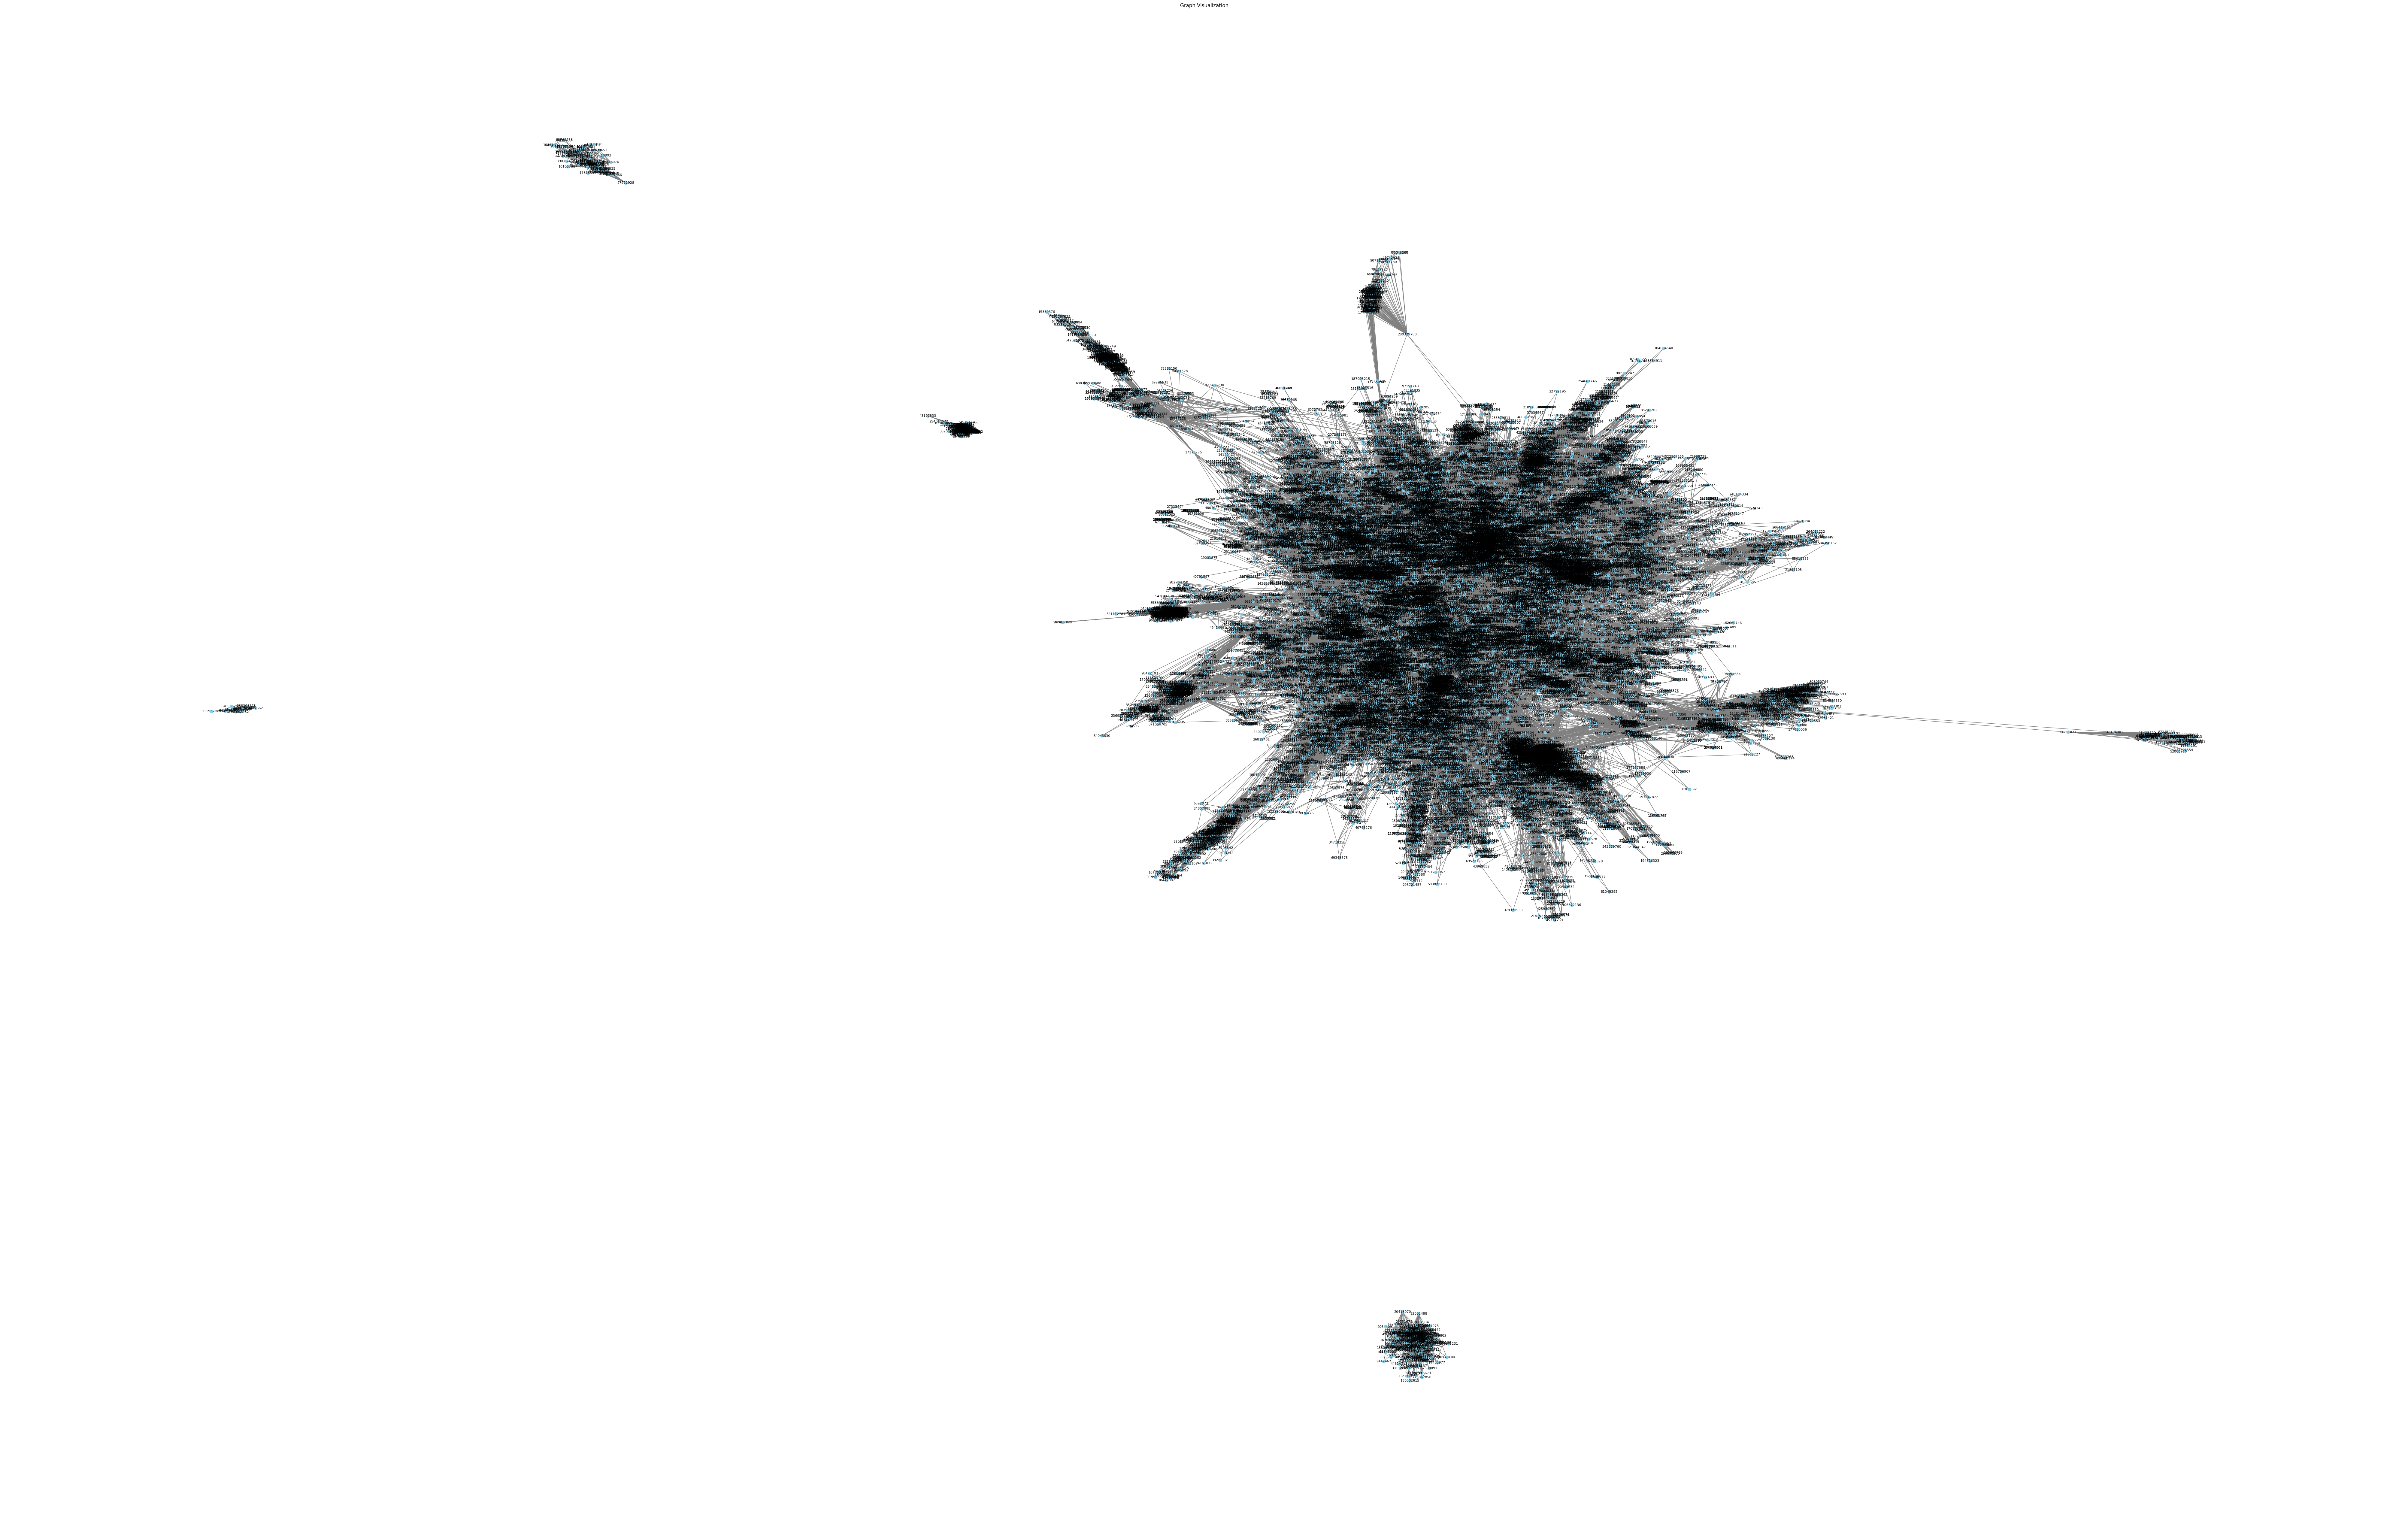

In [ ]:
def PlotGraph(edge_list):
    Gplot = nx.Graph()
    for row in edge_list.select('src', 'dst').take(1000000):
        Gplot.add_edge(row['src'], row['dst'])

    # the layout algorithm for positioning nodes
    pos = nx.spring_layout(Gplot)

    plt.figure(figsize=(80, 50))
    nx.draw(Gplot, pos, with_labels=True, node_size=50, node_color='skyblue', edge_color='gray', font_size=8)
    plt.title('Graph Visualization')
    plt.show()

PlotGraph(graph.edges)

## Displaying some of the edges and the vertices

In [ ]:
# display vertices of the graph
graph.vertices.show(10)

+---+--------------------+
| id|            Features|
+---+--------------------+
| 17|[obviouscorp, sti...|
|107|      [jason, ilona]|
|190|[sfgiants, edcase...|
|224|[joshuatopolsky, ...|
|246|[maxfenton, ftrai...|
|257|[portland, bigsco...|
|414|[, davepell, rcar...|
|418|[dens, smithsonia...|
|528|[irondavy, bradel...|
|586|[jess, anildash, ...|
+---+--------------------+
only showing top 10 rows



In [ ]:
# display edges of the graph
graph.edges.show(10)

+--------+--------+
|     src|     dst|
+--------+--------+
|17137927|56845340|
|17137927|14116024|
|56845340|14116024|
|17137927|62646404|
|17137927|19126166|
|62646404|19126166|
|17137927|12661142|
|17137927|  972651|
|12661142|  972651|
|17137927|15859039|
+--------+--------+
only showing top 10 rows



## Counting the number of vertices and edges

In [ ]:
# count the number of vertices and edges
num_vertices = graph.vertices.count()
num_edges = graph.edges.count()

print("Number of vertices:", num_vertices)
print("Number of edges:", num_edges)

Number of vertices: 68262
Number of edges: 6860727


## Node degree distribution

In [ ]:
degree_distribution = graph.degrees.groupBy("degree").count().orderBy("degree").show(10)

+------+-----+
|degree|count|
+------+-----+
|     2| 3477|
|     4| 3695|
|     6| 2897|
|     8| 2868|
|    10| 2487|
|    12| 2405|
|    14| 2081|
|    16| 2047|
|    18| 1821|
|    20| 1717|
+------+-----+
only showing top 10 rows



## In-degrees and out-degrees

In [ ]:
graph.inDegrees.orderBy("inDegree", ascending=False).show(10)

+---------+--------+
|       id|inDegree|
+---------+--------+
| 40981798|   18695|
| 43003845|   16805|
| 22462180|   15793|
| 34428380|   15655|
|  3359851|   11183|
|115485051|    9383|
| 11348282|    8861|
|  7860742|    8734|
|    15913|    8593|
|  7861312|    7917|
+---------+--------+
only showing top 10 rows



In [ ]:
graph.outDegrees.orderBy("outDegree", ascending=False).show(10)

+---------+---------+
|       id|outDegree|
+---------+---------+
|256497288|    35869|
|314316607|    33206|
| 16987303|    27100|
|217796457|    25109|
|307458983|    21018|
| 24117694|    19657|
|200214366|    19481|
| 89826562|    19438|
|187744415|    19278|
|  2097571|    18851|
+---------+---------+
only showing top 10 rows



</details>

# Enhanced Analysis: Leveraging Advanced Algorithms of GraphFrame on a Subgraph
To explore additional functionalities of GraphFrame, we'll utilize subgraphs due to the sheer scale of the graph, boasting 68,262 nodes interconnected by 6,860,727 edges. It's important to highlight that the inherent parallel processing capabilities of GraphFrame enable the functions we explore in this section to operate efficiently on the entire graph in parallel. However, given the constraints of memory and resources on platforms like Google Colab, tackling such a massive graph directly would demand substantial memory and runtime. Hence, we opt to use subgraphs to showcase the diverse functionalities of the GraphX framework within the available resource constraints.

## Constructing a subgraph with randomly selected edges and relevant vertices

In [ ]:
seed = 42

# the number of random edges
num_random_edges = 3000

# sample random edges
random_edges = graph.edges.orderBy(F.rand(seed)).limit(num_random_edges)

# extract unique source and destination vertices from the selected random edges
unique_vertices_ids = random_edges.select(F.col("src").alias("id")).union(random_edges.select(F.col("dst").alias("id"))).distinct()

# sample the vertices related to the selected edges
random_vertices = graph.vertices.join(unique_vertices_ids, graph.vertices["id"] == unique_vertices_ids["id"], "inner").drop(unique_vertices_ids["id"])

# construct a subgraph containing only the random edges and relevant vertices
subgraph = GraphFrame(random_vertices, random_edges)

In [ ]:
subgraph.vertices.show(5)
subgraph.edges.show(5)

+----+--------------------+
|  id|            Features|
+----+--------------------+
| 989|[msuster, joyce, ...|
|2172|[laughingsquid, t...|
|2426|[glinner, gzahnd,...|
|2691|[storify, instagr...|
|5517|[, jimmyfallon, i...|
+----+--------------------+
only showing top 5 rows

+---------+---------+
|      src|      dst|
+---------+---------+
|222261763|451250774|
| 13317162| 11928542|
|148519842|360110279|
| 87114066| 88048542|
| 28165583|260523318|
+---------+---------+
only showing top 5 rows



## PageRank with a fixed number of iterations

In [ ]:
# PageRank for a fixed number of iterations
subgraph.pageRank(resetProbability=0.15, maxIter=3).vertices.orderBy("pagerank", ascending=False).show(10)

+---------+--------------------+------------------+
|       id|            Features|          pagerank|
+---------+--------------------+------------------+
| 17166447|[erichalvorsen, t...| 9.964891800495328|
| 14691709|[13, ctz, callofd...| 8.023647319083862|
| 18951737|[fbrstreetteam, f...| 7.042305156157047|
| 60968363|[aqueenofhearts, ...|6.4953131903848655|
| 90561258|[mupinbeatjunkie,...| 5.488764858850935|
| 14824849|[alecbaldwin, leo...|5.3438551162430254|
| 43003845|[schzimmydeanie, ...| 5.079188442190626|
| 43933017|[aqueenofhearts, ...| 5.058187772649208|
|430268163|[todoparawhore, w...| 5.008570812668531|
| 14270527|[halo, crixlee, p...| 4.997885900477347|
+---------+--------------------+------------------+
only showing top 10 rows



## Connected-Components

In [ ]:
sc = SparkContext.getOrCreate()
checkpoint_dir = "/content/sub_checkpoint"  # the local checkpoint directory path
sc.setCheckpointDir(checkpoint_dir)

connected_components = subgraph.connectedComponents(algorithm='graphframes', checkpointInterval=2, broadcastThreshold=1000000)

In [ ]:
connected_components.show()

+------+--------------------+---------+
|    id|            Features|component|
+------+--------------------+---------+
|   989|[msuster, joyce, ...|      989|
|  2172|[laughingsquid, t...|     2172|
|  2426|[glinner, gzahnd,...|     2426|
|  2691|[storify, instagr...|     2691|
|  5517|[, jimmyfallon, i...|     5517|
|  5827|[kjsampat, codepo...|     5827|
|  6532|[mittromney, jenn...|     6532|
| 10237|[thatdrew, lame, ...|    10237|
| 10450|[youtube, xeni, s...|     2172|
| 11250|[johnallsopp, ste...|    11250|
| 12587|[ktamura, jc, goo...|     2391|
| 33423|[gruber, hotdogsl...|    33423|
| 44343|[defunkt, kadlac,...|     2172|
| 48903|[brianika, csswg,...|    48903|
| 60273|[masuga, jasonsan...|    48903|
| 65673|[y00b0y, callofdu...|     7846|
| 75533|[newsdotme, highl...|    75533|
| 80703|[garethr, rasputn...|    80703|
|389153|[janl, codepo8, j...|     5517|
|428333|[manchesterderby,...|   428333|
+------+--------------------+---------+
only showing top 20 rows



In [ ]:
# group connected_components dataframe by component ids, count occurrences, and order by counts
component_counts = connected_components.groupBy("component").count().orderBy(F.col("count").desc())

# show the grouped component IDs and their counts
component_counts.show()

+---------+-----+
|component|count|
+---------+-----+
|     7846|  385|
|  2367911|  309|
|  7420552|   47|
|  3991341|   47|
| 16475194|   28|
|  1608991|   28|
|   621583|   25|
|  7613762|   23|
|   612473|   20|
| 14589257|   20|
|    13348|   19|
| 10716292|   18|
| 46948334|   17|
|     2172|   15|
| 16987303|   14|
|  2779821|   13|
| 27527745|   13|
| 14503316|   13|
|    48903|   12|
|  7206432|   11|
+---------+-----+
only showing top 20 rows



## Triangle counting

In [ ]:
# triangle counting on the subgraph
triangle_counts = subgraph.triangleCount()

In [ ]:
triangle_counts.orderBy("count", ascending=False).show()

+-----+---------+--------------------+
|count|       id|            Features|
+-----+---------+--------------------+
|    2| 43003845|[schzimmydeanie, ...|
|    2|216843160|[schzimmydeanie, ...|
|    1|  8088112|[jony2k, mindywhi...|
|    1| 24117694|[ct_legacy, callo...|
|    1| 12611642|[spacex, nutzareu...|
|    1|259842341|[jony2k, hayleywa...|
|    1| 21681252|[dj, djxyanyde, a...|
|    1| 19563357|[sarahdope, carbo...|
|    1| 49253437|[andykipling, win...|
|    1| 34428380|[schzimmydeanie, ...|
|    1| 56860418|[paramoreans, jer...|
|    1| 52405864|[gameinformer, sa...|
|    1| 86221475|[jony2k, hayleywa...|
|    1| 93905958|[callofduty, trey...|
|    1|110315478|[ms_laser, bbh_st...|
|    1|100318079|[acesso_mtv, live...|
|    1|160237722|[jony2k, todopara...|
|    1|104352067|[aqueenofhearts, ...|
|    1|173732041|[jony2k, liveforh...|
|    1|106607901|[, opticdi3sel, j...|
+-----+---------+--------------------+
only showing top 20 rows



## Community Detection using Label Propagation

In [ ]:
# label propagation on subgraph
result = subgraph.labelPropagation(maxIter=5)

# group nodes by their community labels
community_groups = result.groupBy("label").count().orderBy("count", ascending=False)

# show the top communities and their sizes
community_groups.show(10)


+---------+-----+
|    label|count|
+---------+-----+
|206923844|   18|
| 24117694|   18|
|100318079|   15|
|256497288|   15|
| 43003845|   11|
|270449528|   11|
| 18665800|   10|
|198941747|   10|
| 16616109|    9|
| 17658786|    9|
+---------+-----+
only showing top 10 rows



In [ ]:
# join the result dataframe with the vertices dataframe to get the users for each community
community_users = result.join(subgraph.vertices, result.id == subgraph.vertices.id).select(result["label"], result["id"], result["Features"])

# group users by their community labels to collect all users belonging to each community
community_groups = community_users.groupBy("label").agg(F.collect_list("id").alias("users"))

# order the community groups by the count of users in each community in descending order
ordered_community_groups = community_groups.orderBy(F.size("users").desc())

# show the ordered community groups with corresponding users
ordered_community_groups.show()


+---------+--------------------+
|    label|               users|
+---------+--------------------+
| 24117694|[8226492, 1212116...|
|206923844|[17654192, 360085...|
|100318079|[26929220, 276330...|
|256497288|[46948334, 271515...|
| 43003845|[134301914, 15171...|
|270449528|[18951737, 313317...|
| 18665800|[15939644, 163125...|
|198941747|[21247776, 254648...|
| 17658786|[14615871, 174816...|
| 16616109|[18836167, 255349...|
| 15208246|[13348, 3829151, ...|
|  1435461|[10454572, 158291...|
| 20436059|[30313925, 789412...|
| 20689206|[92694295, 184141...|
| 22915745|[26123649, 109184...|
| 64931560|[14999606, 155910...|
|176310143|[236840136, 28016...|
|196327549|[92319025, 123371...|
|285287229|[190017453, 22619...|
|306445007|[28719244, 306808...|
+---------+--------------------+
only showing top 20 rows



## Clustering coefficient

In [ ]:
# clustering coefficient
clustering_coefficient = subgraph.triangleCount().groupBy().avg("count").collect()[0][0]
print("Average Clustering Coefficient:", clustering_coefficient)

Average Clustering Coefficient: 0.01111699311805188


## Link Prediction with Supervised Machine Learning

### Generate a dataset file (.csv) for the Link Prediction Machine Learning task.
You can skip the creation process and download the prepared dataset in the following section to save time.

In [ ]:
vertices_df = subgraph.vertices
vertices_df.show(5)

+----+--------------------+
|  id|            Features|
+----+--------------------+
| 989|[msuster, joyce, ...|
|2172|[laughingsquid, t...|
|2426|[glinner, gzahnd,...|
|2691|[storify, instagr...|
|5517|[, jimmyfallon, i...|
+----+--------------------+
only showing top 5 rows



In [ ]:
edges_df = subgraph.edges
edges_df.show(5)

+---------+---------+
|      src|      dst|
+---------+---------+
|222261763|451250774|
| 13317162| 11928542|
|148519842|360110279|
| 87114066| 88048542|
| 28165583|260523318|
+---------+---------+
only showing top 5 rows



In [ ]:
# cross-join the dataframe with itself to generate all possible pairs of vertices
pair_df = vertices_df.crossJoin(vertices_df.withColumnRenamed('id', 'Node_2')
                                             .withColumnRenamed('Features', 'Features_2')) \
                      .withColumnRenamed('Features', 'Features_1')

# filter out pairs where the node ids are the same
pair_df = pair_df.filter(pair_df['id'] != pair_df['Node_2'])

# merge the features of each pair into a single feature vector
pair_df = pair_df.withColumn('merged_features', concat_ws(' ', pair_df['Features_1'], pair_df['Features_2']))

# check if an edge exists between each pair of vertices
join_condition = (
    (pair_df['id'] == edges_df['src']) & (pair_df['Node_2'] == edges_df['dst']) |
    (pair_df['id'] == edges_df['dst']) & (pair_df['Node_2'] == edges_df['src'])
)
pair_df = pair_df.join(edges_df, join_condition, 'left_outer')

# create a label column with 1 for existing edges and 0 for non-existing edges
pair_df = pair_df.withColumn('label', col('dst').isNotNull().cast('integer'))

# select relevant columns and rename them
pair_df = pair_df.select(col('id').alias('id1'),
                         col('Features_1').alias('features_1'),
                         col('Node_2').alias('id2'),
                         col('Features_2').alias('features_2'),
                         'merged_features',
                         'label')

pair_df.show(5)

+---+--------------------+----+--------------------+--------------------+-----+
|id1|          features_1| id2|          features_2|     merged_features|label|
+---+--------------------+----+--------------------+--------------------+-----+
|989|[msuster, joyce, ...|2172|[laughingsquid, t...|msuster joyce per...|    0|
|989|[msuster, joyce, ...|2426|[glinner, gzahnd,...|msuster joyce per...|    0|
|989|[msuster, joyce, ...|2691|[storify, instagr...|msuster joyce per...|    0|
|989|[msuster, joyce, ...|5517|[, jimmyfallon, i...|msuster joyce per...|    0|
|989|[msuster, joyce, ...|5827|[kjsampat, codepo...|msuster joyce per...|    0|
+---+--------------------+----+--------------------+--------------------+-----+
only showing top 5 rows



In [ ]:
# select id columns, features, and the label columns
pair_df = pair_df.select('id1', 'id2', 'merged_features', 'label')

pair_df.show(5)

+---+----+--------------------+-----+
|id1| id2|     merged_features|label|
+---+----+--------------------+-----+
|989|2172|msuster joyce per...|    0|
|989|2426|msuster joyce per...|    0|
|989|2691|msuster joyce per...|    0|
|989|5517|msuster joyce per...|    0|
|989|5827|msuster joyce per...|    0|
+---+----+--------------------+-----+
only showing top 5 rows



In [ ]:
# group by the 'label' column and count the occurrences of each label
label_counts = pair_df.groupBy('label').count()
label_counts.show()

+-----+--------+
|label|   count|
+-----+--------+
|    1|    5744|
|    0|14263826|
+-----+--------+



As evident from the table above, there is an imbalance between the number of labels 1 and 0. To effectively conduct supervised machine learning, it's essential to address this class imbalance. Thus, we'll generate a dataset (saved in a .csv file) with balanced class proportions.

In [ ]:
# group by the 'label' column and count the occurrences of each label
label_counts = pair_df.groupBy('label').count()

# find the minimum count between label 0 and label 1
min_count = label_counts.select(F.min('count')).first()[0]

# sample an equal number of pairs for each label
balanced_pair_df = pair_df.sampleBy('label', fractions={0: min_count / label_counts.filter(F.col('label') == 0).first()[1],
                                                        1: min_count / label_counts.filter(F.col('label') == 1).first()[1]})

In [ ]:
label_counts = balanced_pair_df.groupBy('label').count()

label_counts.show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 5744|
|    0| 5838|
+-----+-----+



Now that we have achieved balanced class proportions, we will save the obtained class data into a .csv file to utilize as a dataset for machine learning.

In [ ]:
# the path to save the CSV file
csv_path = "balanced_pairs"

# repartition the DataFrame into a single partition to get all data in dataframes in a place
balanced_pair_df_single_partition = balanced_pair_df.coalesce(1)

# save the obtained dataframe as a single CSV file
balanced_pair_df_single_partition.write.csv(csv_path, header=True)

In [ ]:
def zip_csv_file():
    # the folder where the CSV file is located
    folder_path = "balanced_pairs"

    # get a list of all files in the folder
    files = os.listdir(folder_path)

    # search for a file ending with ".csv"
    csv_file = next((file for file in files if file.endswith(".csv")), None)

    if csv_file:
        # construct the full path to the CSV file
        csv_file_path = os.path.join(folder_path, csv_file)

        # construct the path for the zipped file
        zip_file_path = os.path.join(folder_path, "balanced_pair_df.zip")

        # create a zip file
        with zipfile.ZipFile(zip_file_path, 'w') as zipf:
            # Add the CSV file to the zip file
            zipf.write(csv_file_path, arcname=csv_file)

        return "File zipped successfully."

# zip the CSV file
zip_result = zip_csv_file()
print(zip_result)

File zipped successfully.


### Download the preprocessed dataset for the Link Prediction Machine Learning task.

In [ ]:
# URL of the Google Drive file
csv_url = "https://drive.google.com/uc?export=download&id=1qStdOJQclFmPP_f1_1DcDp-WIRGAUpwG"

# get the CSV data directly
response = requests.get(csv_url)
csv_string = response.content.decode('utf-8')

# use pandas to read the CSV string
pdf = pd.read_csv(StringIO(csv_string))

# start a Spark session
spark = SparkSession.builder.master("local[*]").appName("Read CSV Example").getOrCreate()

# convert the pandas DataFrame to a Spark DataFrame
pair_df = spark.createDataFrame(pdf)

In [ ]:
pair_df.show(5)

+----+--------+--------------------+-----+
| id1|     id2|     merged_features|label|
+----+--------+--------------------+-----+
|2172|  779715|laughingsquid top...|    1|
|2172|11136132|laughingsquid top...|    1|
|2172|11136132|laughingsquid top...|    1|
|5517|22915745|jimmyfallon insta...|    1|
|5827| 5680622|kjsampat codepo8 ...|    0|
+----+--------+--------------------+-----+
only showing top 5 rows



### Train a word2vec model to embed the combined features of each pair of vertices connected by an edge

#### Tokenize the combined features of each pair of vertices connected by an edge

In [ ]:
# tokenize the merged features
tokenizer = Tokenizer(inputCol="merged_features", outputCol="tokens")
tokenized_df = tokenizer.transform(pair_df)

#### Train a Word2Vec model to convert tokenized features into numerical vectors and save the trained model
You can skip the training process and download the trained model in the next section to save time.

In [ ]:
# apply Word2Vec to convert tokenized features into numerical vectors
word2vec = Word2Vec(vectorSize=100, minCount=0, inputCol="tokens", outputCol="features_embedded")
model = word2vec.fit(tokenized_df)

# save the trained Word2Vec model
word2vec_model_path = "word2vec_model"
model.save(word2vec_model_path)

In [ ]:
def zip_dir(dir_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(dir_path):
            for file in files:
                zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), dir_path))

# the directory containing the Word2Vec model
word2vec_model_path = "word2vec_model"

# the path where to save the zipped model
zipped_model_path = "word2vec_model.zip"

# zip the Word2Vec model directory
zip_dir(word2vec_model_path, zipped_model_path)

print("Word2Vec model zipped successfully.")

Word2Vec model zipped successfully.


### Load the trained Word2Vec model to save time

In [ ]:
# URL from which to download the zipped Word2Vec model
url = "https://drive.google.com/file/d/1AHgiHZ3iDBAp3nZxRORcvGh3aekHY4Hm/view?usp=share_link"
file_id = url.split("/")[-2]

# modify the URL to get the direct download link
direct_download_url = f"https://drive.google.com/uc?export=download&id={file_id}"

# the directory where to save the downloaded model
download_dir = "loaded_word2vec_model"

# create the download directory if it doesn't exist
if not os.path.exists(download_dir):
    os.makedirs(download_dir)

# the path where to save the downloaded zip file
zip_file_path = os.path.join(download_dir, "word2vec_model.zip")

# download the zip file
response = requests.get(direct_download_url)
with open(zip_file_path, "wb") as zip_file:
    zip_file.write(response.content)

# extract the zip file
with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    zip_ref.extractall(download_dir)

# remove the zip file after extraction
os.remove(zip_file_path)

# load Word2Vec model
loaded_model = Word2VecModel.load(download_dir)

### Utilize the loaded Word2Vec model to obtain the embedded dataframe with relevant columns for the Machine Learning task

In [ ]:
embedded_df = loaded_model.transform(tokenized_df)
embedded_df = embedded_df.select('id1', 'id2', 'features_embedded', 'label')

In [ ]:
embedded_df.show(5)

+----+--------+--------------------+-----+
| id1|     id2|   features_embedded|label|
+----+--------+--------------------+-----+
|2172|  779715|[-0.0679461114128...|    1|
|2172|11136132|[0.03188438039540...|    1|
|2172|11136132|[0.03188438039540...|    1|
|5517|22915745|[-0.0481372071389...|    1|
|5827| 5680622|[-0.1417812345025...|    0|
+----+--------+--------------------+-----+
only showing top 5 rows



In [ ]:
# show one sample of features_embedded
embedded_df.select("features_embedded").show(1, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
embedded_df.count()

11582

### Split the dataset into training and testing sets

In [ ]:
# split the dataset into training and testing sets with an 80:20 ratio
training_data, testing_data = embedded_df.randomSplit([0.8, 0.2], seed=42)

### Train a RandomForest classifier for performing Link Prediction, and save the trained model
You can skip the training process and download the trained model in the next section to save time.

In [ ]:
# define the RandomForestClassifier model
rf = RandomForestClassifier(featuresCol="features_embedded", labelCol="label")

# define a grid of hyperparameters to search. Since the dataset is large, we have tested only one value for each hyperparameter to avoid program crashes.
# However, we have retained the grid for potential use with smaller datasets if needed
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [200]) \
    .addGrid(rf.maxDepth, [30]) \
    .build()

# define an evaluator
evaluator = BinaryClassificationEvaluator(labelCol="label")
# perform cross-validation with grid search
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=3)

# train the model with cross-validation
cv_model = crossval.fit(training_data)

In [ ]:
# get the best model from the CrossValidator
best_model = cv_model.bestModel

# the path where to save the best model
best_model_path = "LinePrediction_model"

# save the best model
best_model.save(best_model_path)

print("Best lp model saved successfully.")

Best lp model saved successfully.


In [ ]:
def zip_dir(dir_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(dir_path):
            for file in files:
                zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), dir_path))

# # Specify the directory containing the LinkPrediction model
# ml_model_path = "lp_model"

# the path where to save the zipped model
zipped_model_path = "lp_model.zip"

# zip the LinkPrediction model directory
zip_dir(best_model_path, zipped_model_path)

print("LinkPrediction model zipped successfully.")

LinkPrediction model zipped successfully.


### Download the trained Link Prediction model to save time

In [ ]:
# URL from which to download the zipped ML model
url = "https://drive.google.com/file/d/1wB_MVg_mt91LaTdNg4XYzIZ39-Codz9F/view?usp=share_link"
file_id = url.split("/")[-2]

# modify the URL to get the direct download link
direct_download_url = f"https://drive.google.com/uc?export=download&id={file_id}"

# the directory where to save the downloaded model
download_dir = "loaded_ml_model"

# create the download directory if it doesn't exist
if not os.path.exists(download_dir):
    os.makedirs(download_dir)

# the path where to save the downloaded zip file
zip_file_path = os.path.join(download_dir, "ml_model.zip")

# download the zip file
response = requests.get(direct_download_url)
with open(zip_file_path, "wb") as zip_file:
    zip_file.write(response.content)

# extract the zip file
with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    zip_ref.extractall(download_dir)

# remove the zip file after extraction
os.remove(zip_file_path)

# load the ML model
loaded_ml_model = RandomForestClassificationModel.load(download_dir)

### Make predictions with the loaded trained Link Prediction model

In [ ]:
# make predictions on the testing data in parallel
predictions = loaded_ml_model.transform(testing_data)

# evaluate the predictions using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="label")
auc = evaluator.evaluate(predictions)

# calculate precision, recall, and F1-score
true_negatives = predictions.filter("prediction == 0 AND label == 0").count()
true_positives = predictions.filter("prediction == 1 AND label == 1").count()
false_positives = predictions.filter("prediction == 1 AND label == 0").count()
false_negatives = predictions.filter("prediction == 0 AND label == 1").count()

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * (precision * recall) / (precision + recall)
accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

# prepare data for the table
data = [
    ["Accuracy", accuracy],
    ["AUC", auc],
    ["Precision", precision],
    ["Recall", recall],
    ["F1 Score", f1_score]
]

print(tabulate(data, headers=["Metric", "Value"]))

Metric        Value
---------  --------
Accuracy   0.860134
AUC        0.929763
Precision  0.838248
Recall     0.890779
F1 Score   0.863715
